# Lista 03

Artificial neural networks for image classification.

In [21]:
READ_DATASETS = False

## Common Functions

In [22]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Plotting

In [23]:
def create_image_panel(images, labels, cols=3, title=None):

    if len(images) != len(labels):
        raise ValueError("Number of images and labels must be equal.")

    rows = int(len(images) / cols) + (len(images) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5, rows * 2))

    for i in range(rows*cols):
        row, col = divmod(i, cols)
        if rows == 1:
            axs = axes[col]
        else:
            axs = axes[row, col]
        if i < len(images):
            axs.imshow(images[i])
            axs.set_title(labels[i])
        axs.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    return fig

In [24]:
colors = [
    "#22223B",
    "#4A4E69",
    "#0B3954",
    "#087E8B",
    "#C81D25",
    "#FF5A5F",
    "#11270b",
    "#3c5a14",
]

In [25]:
def create_bar_plot(labels, values, axis_label=None, title=None,
                    values2=None, axis2_label=None,
                    horizontal=False):

    if len(values) != len(labels):
        raise ValueError("Number of values and labels must be equal.")
    if horizontal and values2 is not None:
        raise ValueError("Cannot have twin axis in a horizontal bar plot.")

    fig, ax1 = plt.subplots(figsize=(5, 3))

    color = colors[0]
    color2 = colors[1]
    if values2 is None:
        width = 0.,
        delta = 0.
    else:
        width = 0.4
        delta = width/2.

    if horizontal:
        ax1.barh(
            labels,
            values,
            color=color,
        )
    else:
        ax1.bar(
            np.arange(len(labels)) - delta,
            values,
            color=color,
            width=width,
            align="center",
        )

    if values2 is not None:
        ax2 = ax1.twinx()
        ax2.bar(
            np.arange(len(labels)) + delta,
            values2,
            color=color2,
            width=width,
            align="center",
        )

    if not horizontal:
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=0)
    if axis_label is not None:
        if horizontal:
            ax1.set_xlabel(axis_label, color=color)
        else:
            ax1.set_ylabel(axis_label, color=color)
    if axis2_label is not None:
        ax2.set_ylabel(axis2_label, color=color2)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig

### Model History

In [26]:
def plot_metrics(history, metrics = ['acc', 'loss']):
    best = np.argmax(history['val_acc'])
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            range(len(history[metric])),
            history[metric],
            color=colors[2],
            label='Train')
        plt.plot(
            range(len(history[metric])),
            history['val_'+metric],
            color=colors[3],
            label='Val')
        plt.plot(best,
                 history['val_'+metric][best],
                 marker='o',
                 color='red')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()

### Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [28]:
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")

In [29]:
def model_summary(X_test, y_test, y_pred, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Accuracy", "Recall")]
        acc = accuracy_score(y_test, y_pred)
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        results.append((
            "All",
            f"{acc:0.4f}",
            f"{balanced_accuracy:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        for i, (label, rec) in enumerate(zip(labels, recall)):
            acc = accuracy_score(y_test[y_test==i], y_pred[y_test==i])
            results.append((
                label,
                f"{acc:0.4f}",
                f"{rec:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        _, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=25)
        conf_matrix_disp.im_.set_clim(0, 600)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()

    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

## Database

 https://medmnist.com/

In [30]:
from medmnist import BloodMNIST

image_size=28
if READ_DATASETS:
    train_dataset = BloodMNIST(split="train", download=True, size=image_size)
    val_dataset = BloodMNIST(split="val", download=True, size=image_size)
    test_dataset = BloodMNIST(split="test", download=True, size=image_size)

    _ = joblib.dump(train_dataset, f"data/train_dataset_{image_size}.sav")
    _ = joblib.dump(val_dataset, f"data/val_dataset_{image_size}.sav")
    _ = joblib.dump(test_dataset, f"data/test_dataset_{image_size}.sav")
else:
    train_dataset = joblib.load(f"data/train_dataset_{image_size}.sav")
    val_dataset = joblib.load(f"data/val_dataset_{image_size}.sav")
    test_dataset = joblib.load(f"data/test_dataset_{image_size}.sav")

In [31]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\tiago.LENOVO-I7\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28

In [32]:
labels = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'immature granulocytes',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet'
]

In [33]:
X_train = train_dataset.imgs[:] / 255.
y_train = train_dataset.labels[:,0]

X_val = val_dataset.imgs[:] / 255.
y_val = val_dataset.labels[:,0]

X_test = test_dataset.imgs[:] / 255.
y_test = test_dataset.labels[:,0]

In [34]:
print(f"Train data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Train data: (11959, 28, 28, 3)
Validation data: (1712, 28, 28, 3)
Test data: (3421, 28, 28, 3)


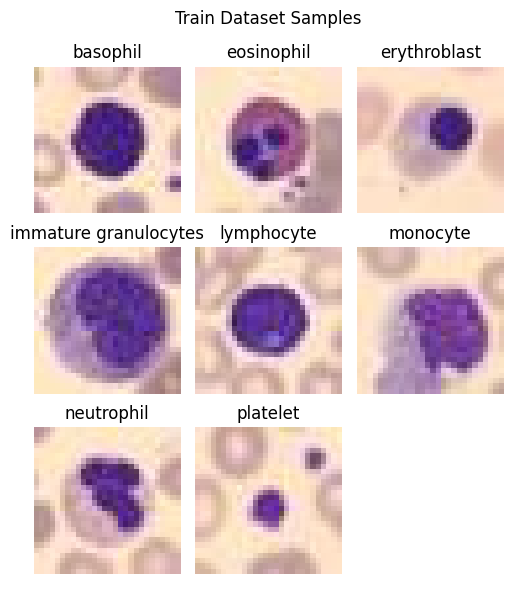

In [35]:
images = []
for i in range(len(labels)):
    images.append(X_train[y_train==i][0])

image_panel = create_image_panel(images, labels, title="Train Dataset Samples")
plt.show(image_panel)

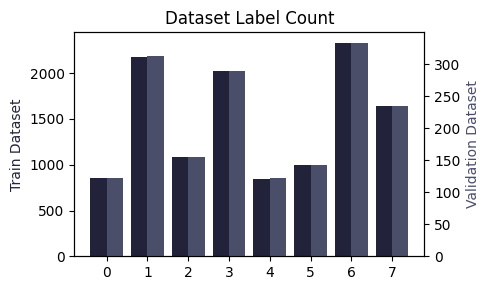

In [36]:
label_count_train = [sum(y_train==i) for i in range(len(labels))]
label_count_val = [sum(y_val==i) for i in range(len(labels))]
create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset",
    values2=label_count_val,
    axis2_label="Validation Dataset",
    title="Dataset Label Count",
)
plt.show()

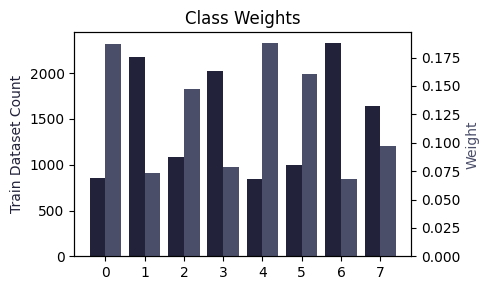

In [37]:
class_weight = {i:1 / sum(y_train==i) for i in range(len(labels))}
total_weights = sum(class_weight.values())
for k,v in class_weight.items():
    class_weight[k] = v / total_weights

create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset Count",
    values2=class_weight.values(),
    axis2_label="Weight",
    title="Class Weights",
)
plt.show()

## Simple CNN

In [38]:
RERUN_CNN = False

In [39]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [40]:
def make_cnn(kernel_width=3, kernel_depth=10, pooling="max", pooling_width=2,
             optimizer="adam", activation="relu", use_augmentation=False):

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=(image_size,image_size,3)))

    if use_augmentation:
        model.add(keras.layers.RandomFlip("horizontal_and_vertical"))
        model.add(keras.layers.RandomRotation(0.2))

    model.add(keras.layers.Conv2D(kernel_depth,
                                  (kernel_width,kernel_width),
                                  activation=activation))
    if pooling=="max":
        model.add(keras.layers.MaxPooling2D((pooling_width, pooling_width)))
    elif pooling=="mean":
        model.add(keras.layers.AveragePooling2D((pooling_width, pooling_width)))
    elif pooling=="global_max":
        model.add(keras.layers.GlobalMaxPooling2D())
    elif pooling=="global_mean":
        model.add(keras.layers.GlobalAveragePooling2D())

    model.add(keras.layers.Flatten(name="Flatten"))
    model.add(keras.layers.Dense(len(labels), activation="softmax", name="Output"))

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

In [69]:
def plot_model(model, name):
    name = f'./report/png/{name}.png'
    return keras.utils.plot_model(
        model=model,
        to_file=name,
        show_shapes=True,
        dpi=75,
        show_layer_activations=True)

In [72]:
def save_model(name, model):
    _ = joblib.dump(model, f"models/{name}.sav")
    model.model().save(f"models/{name}.keras")

def load_model(name, keras_model=False):
    if keras_model:
        model = keras.models.load_model(f"models/{name}.keras")
    else:
        model = joblib.load(f"models/{name}.hist")
    return model

In [43]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=10,
        start_from_epoch=10,
        mode='max',
        restore_best_weights=True
    ),
]

In [44]:
cnn_params = {
    'kernel_width': [3, 5, 7],
    'kernel_depth': [2**i for i in range(3,8)],
    'pooling': ['max', 'mean', 'global_max', 'global_mean'],
    'pooling_width': [2, 3, 4, 5],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'activation': ['relu', 'tanh'],
    'use_augmentation': [False, True],
    'batch_size': [2**i for i in range(4,8)],
    'class_weight':[None, class_weight]
}
cnn_params

{'kernel_width': [3, 5, 7],
 'kernel_depth': [8, 16, 32, 64, 128],
 'pooling': ['max', 'mean', 'global_max', 'global_mean'],
 'pooling_width': [2, 3, 4, 5],
 'optimizer': ['SGD', 'RMSprop', 'Adam'],
 'activation': ['relu', 'tanh'],
 'use_augmentation': [False, True],
 'batch_size': [16, 32, 64, 128],
 'class_weight': [None,
  {0: 0.18718874714339417,
   1: 0.07312462749480597,
   2: 0.1469906106600662,
   3: 0.07871905852229606,
   4: 0.1878501914795899,
   5: 0.16060907609886388,
   6: 0.06844841741037418,
   7: 0.09706927119060975}]}

In [45]:
combinations = np.prod([len(i) for i in cnn_params.values()])
print(f"Number of possible combinations: {combinations}")

Number of possible combinations: 23040


In [46]:
def print_grid_cv_results(cv_results):
    results = [('#','Accuracy', '', 'Parameters'),
            ('','Mean', 'StdDev','')]
    results.append(('Best',
                    f"{cv_results.best_score_:0.4f}",
                    '',
                    f"{cv_results.best_params_}"))
    means = cv_results.cv_results_['mean_test_score']
    stds = cv_results.cv_results_['std_test_score']
    params = cv_results.cv_results_['params']
    for i, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        results.append((
            i,
            f"{mean:0.4f}",
            f"{stdev:0.4f}",
            f"{param}",
        ))
    print_table(results,[2,3])

    return {'param': params,
            'mean': means,
            'std_dev': stds}

In [47]:
best_params = {
    'kernel_width': 3,
    'kernel_depth': 32,
    'pooling': 'max',
    'pooling_width': 2,
    'optimizer': 'SGD',
    'activation': 'relu',
    'use_augmentation': False,
    'batch_size': 32,
    'class_weight':None
}

samples_pc = 0.4
n_train = int(len(y_train) * samples_pc)
n_val = int(len(y_val) * samples_pc)
results = {}

In [48]:
def do_grid_search(tests):
    new_params = {k: cnn_params[k] for k in tests}

    new_model = KerasClassifier(
        model=make_cnn,
        kernel_width=best_params['kernel_width'],
        kernel_depth=best_params['kernel_depth'],
        pooling=best_params['pooling'],
        pooling_width=best_params['pooling_width'],
        activation=best_params['activation'],
        optimizer=best_params['optimizer'],
        use_augmentation=best_params['use_augmentation'],
        batch_size=best_params['batch_size'],
        class_weight=best_params['class_weight'],
        callbacks=callbacks)

    grid_search = GridSearchCV(new_model, new_params, cv=StratifiedKFold(3))
    grid_search_results = grid_search.fit(
        X_train[:n_train], y_train[:n_train], epochs=50,
        validation_data=(X_val[:n_val], y_val[:n_val]),
        callbacks=callbacks)

    results[tests] = print_grid_cv_results(grid_search_results)
    for k in tests:
        best_params[k] = grid_search.best_params_[k]

In [29]:
tests = ('use_augmentation', 'class_weight')
do_grid_search(tests)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - acc: 0.3172 - loss: 1.8328 - val_acc: 0.5950 - val_loss: 1.1694
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.6386 - loss: 1.0921 - val_acc: 0.6769 - val_loss: 0.9240
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7015 - loss: 0.9328 - val_acc: 0.7588 - val_loss: 0.7568
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - acc: 0.7387 - loss: 0.8117 - val_acc: 0.7588 - val_loss: 0.7272
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.7675 - loss: 0.7725 - val_acc: 0.7661 - val_loss: 0.6960
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - acc: 0.7786 - loss: 0.7009 - val_acc: 0.7632 - val_loss: 0.6890
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.7903 - loss: 0.6632 - val_acc: 0.7705 - val_loss: 0.6100
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.7993 - loss: 0.6415 - val_acc: 0.7924 - val_loss: 0.5984
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

In [30]:
best_params

{'kernel_width': 3,
 'kernel_depth': 32,
 'pooling': 'max',
 'pooling_width': 2,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 32,
 'class_weight': None}

In [31]:
tests = ('kernel_width', 'kernel_depth')
do_grid_search(tests)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.2934 - loss: 1.8707 - val_acc: 0.5541 - val_loss: 1.2996
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.5481 - loss: 1.2892 - val_acc: 0.6637 - val_loss: 0.9684
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.6387 - loss: 1.0397 - val_acc: 0.6813 - val_loss: 0.9159
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.6526 - loss: 0.9801 - val_acc: 0.6959 - val_loss: 0.8480
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.6599 - loss: 0.9697 - val_acc: 0.7208 - val_loss: 0.8095
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7007 - loss: 0.9084 - val_acc: 0.7193 - val_loss: 0.7983
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7158 - loss: 0.8484 - val_acc: 0.7471 - val_loss: 0.7594
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7197 - loss: 0.8354 - val_acc: 0.7602 - val_loss: 0.7198
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

In [32]:
best_params

{'kernel_width': 3,
 'kernel_depth': 128,
 'pooling': 'max',
 'pooling_width': 2,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 32,
 'class_weight': None}

In [33]:
tests = ('pooling', 'pooling_width')
do_grid_search(tests)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - acc: 0.3973 - loss: 1.6546 - val_acc: 0.6491 - val_loss: 0.9765
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.6711 - loss: 0.9279 - val_acc: 0.7471 - val_loss: 0.7436
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.7185 - loss: 0.8092 - val_acc: 0.7632 - val_loss: 0.6900
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.7326 - loss: 0.7742 - val_acc: 0.7734 - val_loss: 0.6345
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.7564 - loss: 0.6799 - val_acc: 0.8099 - val_loss: 0.5405
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.7761 - loss: 0.6632 - val_acc: 0.7982 - val_loss: 0.5674
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - acc: 0.7924 - loss: 0.6163 - val_acc: 0.8319 - val_loss: 0.5242
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - acc: 0.8050 - loss: 0.5743 - val_acc: 0.8319 - val_loss: 0.4852
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/

In [34]:
best_params

{'kernel_width': 3,
 'kernel_depth': 128,
 'pooling': 'max',
 'pooling_width': 2,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 32,
 'class_weight': None}

In [35]:
tests = ('optimizer', 'activation',  'batch_size')
do_grid_search(tests)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.3936 - loss: 1.6064 - val_acc: 0.6067 - val_loss: 1.0678
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.6504 - loss: 0.9942 - val_acc: 0.7193 - val_loss: 0.7535
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7294 - loss: 0.8027 - val_acc: 0.7865 - val_loss: 0.6068
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7579 - loss: 0.7182 - val_acc: 0.7763 - val_loss: 0.6299
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7622 - loss: 0.6779 - val_acc: 0.7924 - val_loss: 0.5723
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7997 - loss: 0.6019 - val_acc: 0.8143 - val_loss: 0.5496
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.7949 - loss: 0.5978 - val_acc: 0.8363 - val_loss: 0.4629
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 0.8090 - loss: 0.5436 - val_acc: 0.8509 - val_loss: 0.4543
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/

In [36]:
best_params

{'kernel_width': 3,
 'kernel_depth': 128,
 'pooling': 'max',
 'pooling_width': 2,
 'optimizer': 'Adam',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 16,
 'class_weight': None}

#### Results

In [49]:
results[('kernel_width', 'kernel_depth')] = {
    'param': [{'kernel_depth': 8, 'kernel_width': 3}  , {'kernel_depth': 8, 'kernel_width': 5}  , {'kernel_depth': 8, 'kernel_width': 7}  , {'kernel_depth': 16, 'kernel_width': 3} , {'kernel_depth': 16, 'kernel_width': 5} , {'kernel_depth': 16, 'kernel_width': 7} , {'kernel_depth': 32, 'kernel_width': 3} , {'kernel_depth': 32, 'kernel_width': 5} , {'kernel_depth': 32, 'kernel_width': 7} , {'kernel_depth': 64, 'kernel_width': 3} , {'kernel_depth': 64, 'kernel_width': 5} , {'kernel_depth': 64, 'kernel_width': 7} , {'kernel_depth': 128, 'kernel_width': 3}, {'kernel_depth': 128, 'kernel_width': 5}, {'kernel_depth': 128, 'kernel_width': 7}],
    'mean': [0.8277, 0.8248, 0.8426, 0.8405, 0.8488, 0.8499, 0.8574, 0.8591, 0.8451, 0.8687, 0.8706, 0.8547, 0.8783, 0.8555, 0.8641],
    'std_dev': [0.0055, 0.0113, 0.0082, 0.0128, 0.0071, 0.0033, 0.0154, 0.0098, 0.0099, 0.0057, 0.0151, 0.0030, 0.0071, 0.0023, 0.0003]
    }

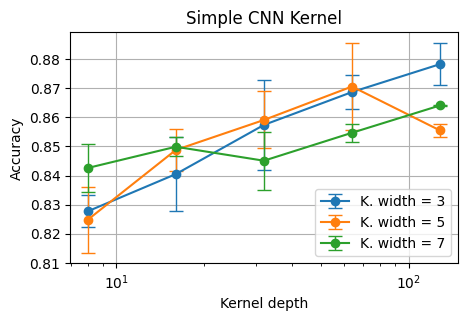

In [56]:
fig = plt.figure(figsize=(5,3))
r = results[('kernel_width', 'kernel_depth')]
for w in cnn_params['kernel_width']:
    mean = [mean for (mean, param) in zip(r['mean'], r['param']) if param['kernel_width'] == w]
    stdev = [stdev for (stdev, param) in zip(r['std_dev'], r['param']) if param['kernel_width'] == w]

    plt.errorbar(cnn_params['kernel_depth'],
                 mean,
                 yerr=stdev,
                 capsize=5, elinewidth=1, marker='o',
                 label=f'K. width = {w}',)
plt.xlabel('Kernel depth')
plt.ylabel('Accuracy')
plt.title('Simple CNN Kernel')
plt.legend(loc="lower right")
plt.xscale('log')
plt.grid()
plt.savefig('report/png/CNN_kernel.png')
plt.show()


In [57]:
callbacks_final = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=20,
        start_from_epoch=30,
        mode='max',
        restore_best_weights=True
    ),
]

cnn_simple = KerasClassifier(
    model=make_cnn,
    callbacks=callbacks_final,
    **best_params)

history_ = cnn_simple.fit(
    X_train, y_train,epochs=10,
    validation_data=(X_val, y_val))

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.4990 - loss: 1.3849 - val_acc: 0.7132 - val_loss: 0.7944
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.7419 - loss: 0.7620 - val_acc: 0.7903 - val_loss: 0.6077
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.8067 - loss: 0.5951 - val_acc: 0.8078 - val_loss: 0.5295
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.8300 - loss: 0.5164 - val_acc: 0.8189 - val_loss: 0.5120
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8487 - loss: 0.4619 - val_acc: 0.8411 - val_loss: 0.4550
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8593 - loss: 0.4237 - val_acc: 0.8598 - val_loss: 0.4074
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8725 - loss: 0.3784 - val_acc: 0.8662 - val_loss: 0.4188
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.8793 - loss: 0.3574 - val_acc: 0.8797 - val_loss: 0.3634
Epoch 9/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - ac

In [58]:
y_pred = cnn_simple.predict(X_test)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


| Class                 | Accuracy | Recall |
---------------------------------------------
| All                   | 0.8772   | 0.8519 |
---------------------------------------------
| basophil              | 0.8770   | 0.8770 |
| eosinophil            | 0.9663   | 0.9663 |
| erythroblast          | 0.8264   | 0.8264 |
| immature granulocytes | 0.8446   | 0.8446 |
| lymphocyte            | 0.8354   | 0.8354 |
| monocyte              | 0.5563   | 0.5563 |
| neutrophil            | 0.9174   | 0.9174 |
| platelet              | 0.9915   | 0.9915 |


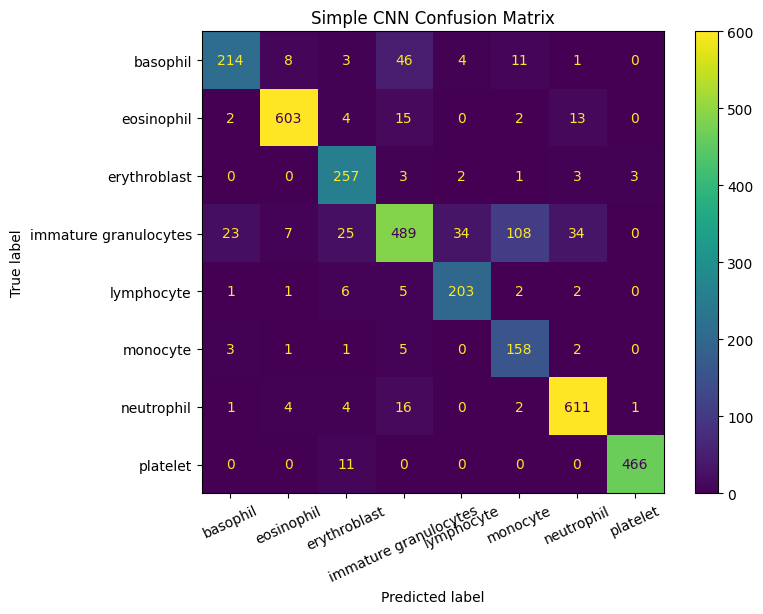

In [79]:
model_summary(X_test, y_test, y_pred, labels, "Simple CNN", "CNN_Simple_CM")

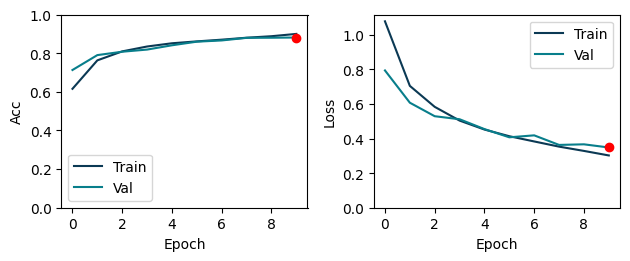

In [77]:
plot_metrics(history_.history_)
plt.savefig('./Report/png/CNN_Simple_history.png')
plt.show()

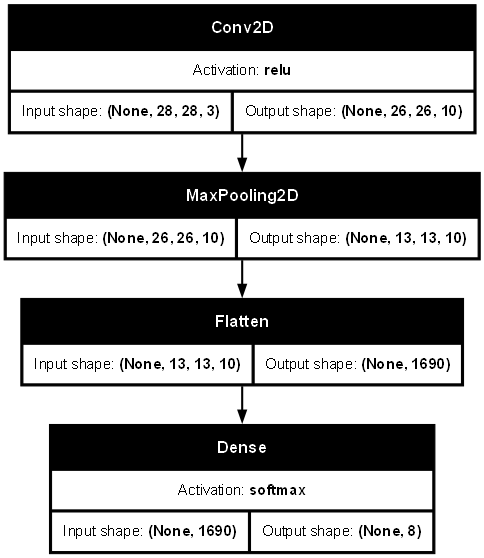

In [78]:
plot_model(model=cnn_simple.model(), name='CNN_Simple_model')

In [73]:
save_model(name="CNN_Simple", model=cnn_simple)